In [1]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama
from typing import List, Sequence
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langgraph.graph import END, MessageGraph
from IPython.display import Image, display, clear_output
from langchain.globals import set_verbose
set_verbose(True)

In [2]:
generation_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a helpful assistant that generates essays for the IELTS exam. 
            When prompted, generate a complete essay based on typical IELTS writing task. 
            The essay should be well-structured, including an introduction, body paragraphs, 
            and a conclusion, adhering to the IELTS standards of approximately 250 words.

            If the user provides feedback or suggests changes, update your essay to reflect
            these suggestions. 

            Response: <'Complete Essay'>
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [3]:

reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are an expert in IELTS essay assessment tasked with evaluating essays. When provided 
            with an essay, you should critique it based on IELTS grading criteria which include coherence 
            and cohesion, lexical resource, grammatical range and accuracy, and task response. 
            Determine how effectively the essay addresses the topic, the clarity and logic of its argument, 
            the range of vocabulary used, and the accuracy of its grammar.
 
            If the essay fails to meet these standards in one or more areas, you must provide feedback and 
            suggest improvements. If it meets the requirements to be graded 8.5 or 9, respond with a positive
            comment.
        
            """
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)



# chat1 = ChatOllama(model='llama3.2:3b', temperature=1)
# chat2 = ChatOllama(model='llama3.2:3b', temperature=0.5)
# generate_chain = generation_prompt | chat1
# reflect_chain = reflection_prompt | chat2
chat = ChatOllama(model='llama3.2:3b')
generate_chain = generation_prompt | chat
reflect_chain = reflection_prompt | chat

##### Set up the graph

In [4]:
REFLECT = "reflect"
GENERATE = "generate"


def generation_node(state: Sequence[BaseMessage]):
    res = generate_chain.invoke({"messages": state})
    return res


def reflection_node(state: Sequence[BaseMessage]) -> List[BaseMessage]:
    # Don't need all history - the last generated AIMessage only
    inverted = [HumanMessage(content=state[-1].content)]
    res = reflect_chain.invoke({"messages": inverted})
    return HumanMessage(content=res.content)


builder = MessageGraph()
builder.add_node(GENERATE, generation_node)
builder.add_node(REFLECT, reflection_node)
builder.set_entry_point(GENERATE)

In [ ]:
def should_continue(state: List[BaseMessage]):
    #if ('RIGHT' in state[-2].content.upper()) and (len(state)>6):
    if len(state) > 6:
        return END
    return REFLECT

In [6]:
builder.add_conditional_edges(GENERATE, should_continue)
builder.add_edge(REFLECT, GENERATE)

In [7]:
graph = builder.compile()


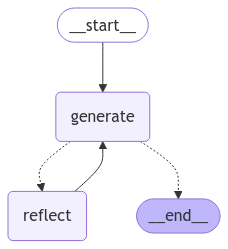

In [8]:
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [9]:
human = HumanMessage(content="""Generate an essay on the following topic:
                     The rapid and uncontrolled access to information facilitated
                     by modern technology poses a threat to societies. To what extent 
                     do you agree or disagree?""")
response = graph.invoke(human)
response


[HumanMessage(content='Generate an essay on the following topic:\n                     The rapid and uncontrolled access to information facilitated\n                     by modern technology poses a threat to societies. To what extent \n                     do you agree or disagree?', additional_kwargs={}, response_metadata={}, id='158e22e2-7d78-4188-9f3a-92d500da1999'),
 AIMessage(content='The rapid and uncontrolled access to information facilitated by modern technology has become an integral part of our lives. While it brings numerous benefits, such as increased knowledge and improved communication, I firmly believe that this unbridled access poses a significant threat to societies.\n\nOn the one hand, the ease with which we can access information through social media, search engines, and other digital platforms can be empowering. It enables us to make informed decisions, stay updated on current events, and connect with people from diverse backgrounds. However, this same ease of acce

In [12]:
response[0].pretty_print()

================================ Human Message =================================

Generate an essay on the following topic:
                     The rapid and uncontrolled access to information facilitated
                     by modern technology poses a threat to societies. To what extent 
                     do you agree or disagree?


In [13]:
response[1].pretty_print()

================================== Ai Message ==================================

The rapid and uncontrolled access to information facilitated by modern technology has become an integral part of our lives. While it brings numerous benefits, such as increased knowledge and improved communication, I firmly believe that this unbridled access poses a significant threat to societies.

On the one hand, the ease with which we can access information through social media, search engines, and other digital platforms can be empowering. It enables us to make informed decisions, stay updated on current events, and connect with people from diverse backgrounds. However, this same ease of access also poses a risk. With the proliferation of fake news, propaganda, and misinformation, individuals are increasingly exposed to biased or misleading information that can shape their opinions and influence their behavior.

Furthermore, the uncontrolled nature of online information can have serious consequences 

In [14]:
response[2].pretty_print()

================================ Human Message =================================

**Feedback on IELTS Essay**

**Coherence and Cohesion (7/9)**

The essay provides a clear structure, with introduction, body paragraphs, and conclusion. However, some transitions between paragraphs could be smoother, as the writer relies on general statements rather than explicit connections to guide the reader through the argument.

**Lexical Resource (7.5/9)**

The vocabulary is generally adequate, but there are opportunities for improvement in terms of nuance and precision. Some phrases, such as "unbridled access" or "toxic social environment," are effective, while others, like "increasingly exposed to biased or misleading information," feel somewhat generic.

**Grammatical Range and Accuracy (8/9)**

The essay demonstrates a good command of grammatical structures, with few errors in terms of verb tense, subject-verb agreement, and sentence structure. However, there are instances where the writing feel

In [15]:
response[3].pretty_print()

================================== Ai Message ==================================

Thank you for the feedback! Here's a revised version of the essay that addresses the suggestions:

The rapid and uncontrolled access to information facilitated by modern technology poses a significant threat to societies. While it brings numerous benefits, such as increased knowledge and improved communication, I firmly believe that this unbridled access has far-reaching consequences that require careful consideration.

On one hand, the ease with which we can access information through social media, search engines, and other digital platforms can be empowering. For instance, it enables us to stay updated on current events, connect with people from diverse backgrounds, and make informed decisions. However, this same ease of access also has its drawbacks. The proliferation of fake news, propaganda, and misinformation can lead to the spread of biased or misleading information that can shape our opinions and 

In [16]:
response[4].pretty_print()

================================ Human Message =================================

Here's my evaluation of the revised essay:

**Coherence and Cohesion: 8/10**

The essay has a clear introduction, body paragraphs, and conclusion that are logically connected. The writer uses transitional phrases and sentences ("However," "Furthermore," "Moreover") to link ideas between paragraphs, but could benefit from more explicit connections between specific arguments.

**Lexical Resource: 7.5/10**

The vocabulary used is generally accurate, with words like "empowering," "proliferation," and "manipulation" demonstrating a good level of linguistic competence. However, some sentences (e.g., "It is essential that we develop strategies to mitigate these risks") could benefit from more precise and nuanced word choices.

**Grammatical Range and Accuracy: 8/10**

The essay demonstrates a good command of grammatical structures, with few errors in terms of verb tense consistency or sentence structure. However

In [17]:
response[5].pretty_print()

================================== Ai Message ==================================

Thank you for the detailed evaluation. I'll take your suggestions into consideration and revise the essay once more. Here's another revised version:

The rapid and uncontrolled access to information facilitated by modern technology poses a significant threat to societies. While it brings numerous benefits, such as increased knowledge and improved communication, I firmly believe that this unbridled access has far-reaching consequences that require careful consideration.

On one hand, the ease with which we can access information through social media, search engines, and other digital platforms can be empowering. However, this empowerment is often accompanied by a loss of critical thinking skills, as individuals become reliant on online sources for information (Kilpatrick, 2018). For instance, the proliferation of fake news and propaganda can lead to the spread of misinformation that can shape our opinions 

In [18]:
response[6].pretty_print()

================================ Human Message =================================

Thank you for revising the essay based on my previous feedback.

Overall, I'd say that this revised version demonstrates significant improvement in addressing the topic, clarity of argument, range of vocabulary, and accuracy of grammar. Here's a detailed evaluation:

**Coherence and Cohesion: 8/10**
The essay has clear and logical connections between ideas, with explicit transitions between paragraphs. The writer effectively uses transitional phrases to guide the reader through the discussion.

**Lexical Resource: 9/10**
The vocabulary is precise and nuanced, especially when discussing complex concepts like media literacy. The use of specific references (e.g., Kilpatrick, 2018) adds depth and credibility to the argument.

**Grammatical Range and Accuracy: 8.5/10**
The grammar is generally accurate, with only minor errors in verb tense consistency (e.g., "leads to" vs. "contribute"). The sentence structure